In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Multiply, BatchNormalization, LeakyReLU, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist


In [2]:
(X_train, y_train), (_, _) = mnist.load_data()
# Normalize data to [-1, 1]
X_train = (X_train.astype('float32') - 127.5) / 127.5
X_train = X_train.reshape(X_train.shape[0], 784) # Flatten images for the MLP



In [3]:
def build_generator(latent_dim, num_classes=10):
    # Latent input and label
    latent = Input(shape=(latent_dim,))
    image_class = Input(shape=(1,), dtype='int32')
    
    # Embedding for categorical input
    cls = Embedding(num_classes, latent_dim)(image_class)
    cls = Flatten()(cls)
    model_input = Multiply()([latent, cls])

    # Generator network
    x = Dense(256)(model_input)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(784, activation='tanh')(x)
    out = Reshape((28, 28))(x)

    # Model definition
    model = Model([latent, image_class], out)
    return model



In [4]:
def build_discriminator(num_classes=10):
    img = Input(shape=(28, 28))
    img_class = Input(shape=(1,), dtype='int32')
    
    # Embedding for categorical input
    cls = Embedding(num_classes, 784)(img_class)
    cls = Flatten()(cls)
    flat_img = Flatten()(img)

    # Merged model by multiplying
    model_input = Multiply()([flat_img, cls])

    x = Dense(512)(model_input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.2)(x)
    validity = Dense(1, activation='sigmoid')(x)

    # Model definition
    model = Model([img, img_class], validity)
    return model


In [5]:
def build_cgan(generator, discriminator):
    z_dim = 100
    num_classes = 10
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
    discriminator.trainable = False

    z = Input(shape=(z_dim,))
    label = Input(shape=(1,))
    img = generator([z, label])
    valid = discriminator([img, label])

    cgan = Model([z, label], valid)
    cgan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
    return cgan


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os

if not os.path.exists('images'):
    os.makedirs('images')
if not os.path.exists('models'):
    os.makedirs('models')
    
for x in range(10):
    if not os.path.exists(f'images/{x}'):
        os.makedirs(f'images/{x}')

def sample_images(generator, epoch, z_dim, num_classes=10):
    r, c = 2, 5
    noise = np.random.normal(0, 1, (r * c, z_dim))
    sampled_labels = np.arange(0, 10).reshape(-1, 1)
    gen_imgs = generator.predict([noise, sampled_labels])

    # Rescale images from [-1, 1] to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    for i in range(gen_imgs.shape[0]):
        plt.imsave(f'images/{i}/epoch_{epoch}.png', gen_imgs[i, :, :], cmap='gray')

    fig, axs = plt.subplots(r, c, figsize=(10, 4))
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt], cmap='gray')  # Adjusted indexing here
            axs[i, j].axis('off')
            axs[i, j].set_title(f"Digit: {sampled_labels[cnt][0]}")  # Ensuring labels are properly shown
            cnt += 1
    plt.show()


In [7]:
def train(generator, discriminator, cgan, epochs, batch_size=128, save_interval=50):
    # Load and preprocess data
    (X_train, y_train), (_, _) = mnist.load_data()
    X_train = (X_train.astype('float32') - 127.5) / 127.5
    X_train = X_train.reshape(X_train.shape[0], 28, 28)  # Flatten images

    half_batch = int(batch_size / 2)
    z_dim = 100
    

    for epoch in range(epochs):
        # Select a random half batch of images
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs, labels = X_train[idx], y_train[idx]
        imgs = imgs.reshape(-1, 28, 28)  # Ensure images are flattened
        print(imgs.shape)
        labels = labels.reshape(-1, 1)  # Ensure labels are in the correct shape

        noise = np.random.normal(0, 1, (half_batch, z_dim))
        gen_imgs = generator.predict([noise, labels])

        # Train on real and generated data
        d_loss_real = discriminator.train_on_batch([imgs, labels], np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Training the generator
        noise = np.random.normal(0, 1, (batch_size, z_dim))
        sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
        valid_y = np.array([1] * batch_size)

        # Train the generator
        g_loss = cgan.train_on_batch([noise, sampled_labels], valid_y)

        # Output training status
        if epoch % save_interval == 0:
            print(f"Epoch {epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")
            sample_images(generator, epoch, z_dim)



(16, 28, 28)
1/1 [==============================] - 0s 202ms/step


Epoch 0 [D loss: 0.6890873312950134, acc.: 43.75%] [G loss: 0.6798433065414429]
1/1 [==============================] - 0s 256ms/step


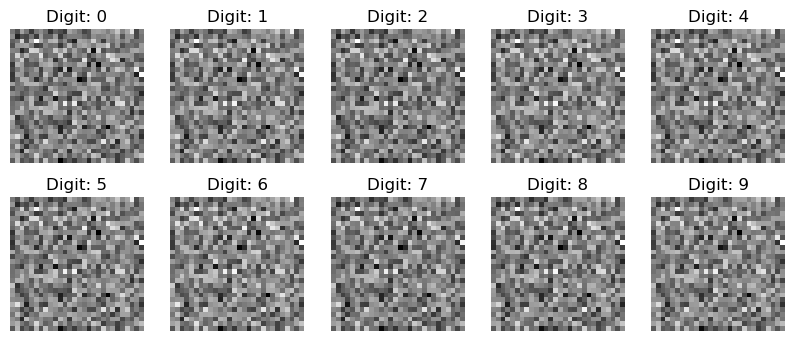

(16, 28, 28)
1/1 [==============================] - 0s 20ms/step
(16, 28, 28)
1/1 [==============================] - 0s 20ms/step
(16, 28, 28)
1/1 [==============================] - 0s 20ms/step
(16, 28, 28)
1/1 [==============================] - 0s 19ms/step
(16, 28, 28)
1/1 [==============================] - 0s 20ms/step
(16, 28, 28)
1/1 [==============================] - 0s 20ms/step
(16, 28, 28)
1/1 [==============================] - 0s 23ms/step
(16, 28, 28)
1/1 [==============================] - 0s 19ms/step
(16, 28, 28)
1/1 [==============================] - 0s 19ms/step
(16, 28, 28)
1/1 [==============================] - 0s 20ms/step
(16, 28, 28)
1/1 [==============================] - 0s 21ms/step
(16, 28, 28)
1/1 [==============================] - 0s 20ms/step
(16, 28, 28)
1/1 [==============================] - 0s 20ms/step
(16, 28, 28)
1/1 [==============================] - 0s 20ms/step
(16, 28, 28)
1/1 [==============================] - 0s 19ms/step
(16, 28, 28)
1/1 [=======

KeyboardInterrupt: 

In [8]:
latent_dim = 100
generator = build_generator(latent_dim)
discriminator = build_discriminator()
cgan = build_cgan(generator, discriminator)

train(generator, discriminator, cgan, epochs=30000, batch_size=32, save_interval=1000)